Detect anomelis in system log 

PART 1 — Create a Synthetic Dataset

Imports & Setup

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)


pandas → handles tables

numpy → generates random numbers

seed(42) → makes results repeatable

Generate 1000 rows of fake system data

In [2]:
n_samples = 1000
data = {
    'timestamp': pd.date_range(start='2024-01-01', periods=n_samples, freq='h'),
    'cpu_usage': np.random.normal(50, 10, n_samples),
    'memory_usage': np.random.normal(60, 15, n_samples),
    'network_latency': np.random.normal(100, 20, n_samples),
    'disk_io': np.random.normal(75, 10, n_samples),
    'error_rate': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])
}


What this means:

timestamp → one row per hour starting Jan 1, 2024

cpu_usage → around 50% ± randomness

memory_usage → around 60%

network_latency → around 100 ms

disk_io → around 75 MB/s

error_rate →

0 = no error

1 = error

only 5% rows contain an error

This mimics real server logs

Create DataFrame

In [3]:
df = pd.DataFrame(data)
print(df.head())
print(df.info())


            timestamp  cpu_usage  memory_usage  network_latency    disk_io  \
0 2024-01-01 00:00:00  54.967142     80.990332        86.496435  55.921924   
1 2024-01-01 01:00:00  48.617357     73.869505        97.109627  66.396150   
2 2024-01-01 02:00:00  56.476885     60.894456        84.151602  70.863945   
3 2024-01-01 03:00:00  65.230299     50.295948        93.840769  93.876877   
4 2024-01-01 04:00:00  47.658466     70.473350        62.127707  80.565531   

   error_rate  
0           0  
1           0  
2           1  
3           0  
4           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1000 non-null   datetime64[ns]
 1   cpu_usage        1000 non-null   float64       
 2   memory_usage     1000 non-null   float64       
 3   network_latency  1000 non-null   float64       
 4   disk_io

Anomaly Detection Using Isolation Forest

Isolation Forest is a machine-learning algorithm used to detect unusual data points.

In [4]:
numeric_data = df.select_dtypes(include=[float, int])


This keeps only numeric columns and drops timestamp (because ML models can't use dates directly).

Isolation Forest Mode

In [5]:
from sklearn.ensemble import IsolationForest

def detect_anomalies(data):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(data)
    anomalies = model.predict(data)
    return anomalies


What this does:

contamination=0.05 → expect about 5% anomalies

model.predict() returns:

1 → normal point

-1 → anomaly

Add anomaly label to the dataframe

In [6]:
df['anomaly'] = detect_anomalies(numeric_data)
print(df['anomaly'].value_counts())


anomaly
 1    950
-1     50
Name: count, dtype: int64


This shown unusual behaviour of system not exact root cause too find we need to explore column level first then go for row off identified column 

, we have implemented the isolation forest algorithm to detect anomalies. First, we define a detectAnomalies function, and then we call that function on the numeric data from above. Note that numeric data only consists of floats and ints of columns from our dataset that are of the type either float or int. This excludes the timestamp column. This is necessary to produce accurate results, because timestamp probably has no bearing on errors. We can see here that we have classified the data into 950 non-anomalous rows and 50 anomalous rows. Isolation forest is a great tool for identifying outliers, which in this case represent system anomalies. 
These anomalies will trigger further diagnostics in our troubleshooting agent

PART 3 — Identify which column triggered the anomaly

You compute z-scores, which show how many standard deviations a value is from normal.

In [7]:
from scipy.stats import zscore
z_scores = numeric_data.apply(zscore)


If a value has z-score > 3, it is far away from normal.

Function to find anomalous columns per row by  using z score

In [8]:
def find_anomalous_columns(row, threshold=3):
    return [col for col in numeric_data.columns if abs(z_scores.loc[row.name, col]) > threshold]


this return  metics like-["cpu_usage", "network_latency"]


Detect anvomellis in row -Apply only to rows flagged as anomalies

In [10]:
df['anomalous_columns'] = df.apply(
    lambda row: find_anomalous_columns(row) if row['anomaly'] == -1 else [],
    axis=1
)


If the row is normal → []
If anomaly → list of offending columns

✔ Print only anomaly rows

In [11]:
print(df[df['anomaly'] == -1][['timestamp', 'anomaly', 'anomalous_columns']])


              timestamp  anomaly              anomalous_columns
37  2024-01-02 13:00:00       -1                   [error_rate]
38  2024-01-02 14:00:00       -1                   [error_rate]
62  2024-01-03 14:00:00       -1                   [error_rate]
132 2024-01-06 12:00:00       -1                   [error_rate]
179 2024-01-08 11:00:00       -1                   [error_rate]
192 2024-01-09 00:00:00       -1                   [error_rate]
208 2024-01-09 16:00:00       -1                   [error_rate]
241 2024-01-11 01:00:00       -1                   [error_rate]
245 2024-01-11 05:00:00       -1                   [error_rate]
251 2024-01-11 11:00:00       -1                   [error_rate]
262 2024-01-11 22:00:00       -1        [cpu_usage, error_rate]
272 2024-01-12 08:00:00       -1                   [error_rate]
285 2024-01-12 21:00:00       -1                   [error_rate]
315 2024-01-14 03:00:00       -1                   [error_rate]
329 2024-01-14 17:00:00       -1        

Generates realistic synthetic monitoring data
✔ Detects anomalies (unusual behavior) with Isolation Forest
✔ Identifies which metrics (CPU, memory, latency...) caused the anomaly
✔ Outputs anomaly timestamps + offending columns

In [15]:
!pip install matplotlib


In [21]:
import sys
print(sys.executable)


/anaconda/envs/bert-py310-cpu/bin/python


In [22]:
!{sys.executable} -m pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 97.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 97.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 121.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


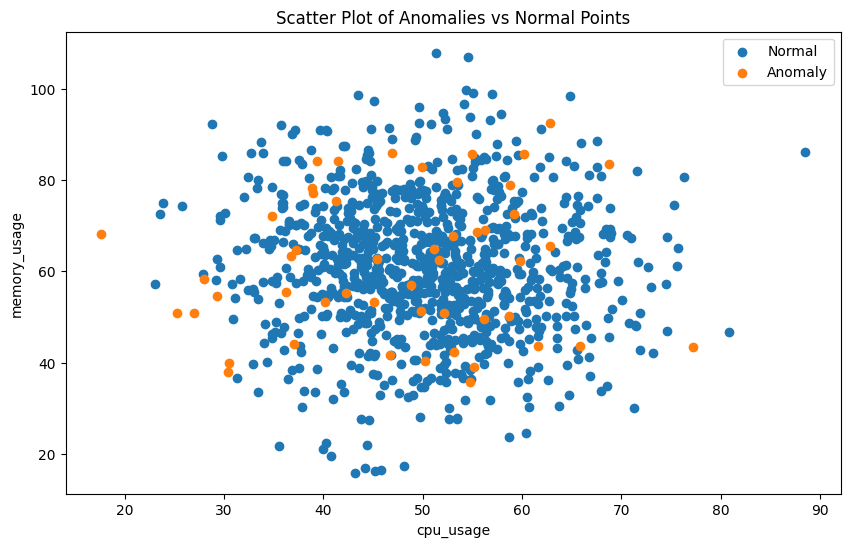

In [23]:
import matplotlib.pyplot as plt

# Use two features for visualization (you can change these)
x_feature = 'cpu_usage'
y_feature = 'memory_usage'

# Separate normal and anomalous points
normal_data = df[df['anomaly'] == 1]
anomaly_data = df[df['anomaly'] == -1]

# Create scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(normal_data[x_feature], normal_data[y_feature], label="Normal")
plt.scatter(anomaly_data[x_feature], anomaly_data[y_feature], label="Anomaly")

plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot of Anomalies vs Normal Points")
plt.legend()
plt.show()
